## In this notebook, we will explore ARIMA.

# ARIMA
Autoregressive Integrated Moving Average (ARIMA) is a commonly-used local statistical algorithm for time-series forecasting. ARIMA captures standard temporal structures (patterned organizations of time) in the input dataset. 

The ARIMA algorithm is especially useful for datasets that can be mapped to stationary time series. The statistical properties of stationary time series, such as autocorrelations, are independent of time. Datasets with stationary time series usually contain a combination of signal and noise. The signal may exhibit a pattern of sinusoidal oscillation or have a seasonal component. ARIMA acts like a filter to separate the signal from the noise, and then extrapolates the signal in the future to make predictions.

We will use statsmodels to explore ARIMA first. [Statsmodels](https://www.statsmodels.org/stable/about.html#module-statsmodels) is a Python module that provides classes and functions for the estimation of many different statistical models, as well as for conducting statistical tests, and statistical data exploration. An extensive list of result statistics are available for each estimator. 

In [ ]:
# install statmodels if your environment doesn't install it before
!conda install -c conda-forge statsmodels -y

In [1]:
%matplotlib inline

import sys
from dateutil.parser import parse
import json
from random import shuffle
import random
import datetime
import os

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 15, 6

In [2]:
# 2019-07-10 00:00:00 to 2019-10-09 23:59:59

DATETIME_START_OF_TRAIN = "2019-07-10 00:00:00"
DATETIME_END_OF_TRAIN = "2019-09-17 00:00:00"
DATETIME_START_OF_TEST = DATETIME_END_OF_TRAIN
DATETIME_END_OF_TEST = "2019-09-24 00:00:00"
DATETIME_START_OF_PREDICT = DATETIME_END_OF_TEST
DATETIME_END_OF_PREDICT = "2019-10-01 00:00:00"

# we use 1 day frequency for the time series
freq = '1D'

# we predict for 7 days
prediction_length = 7

# we also use 14 days as context length, this is the number of state updates accomplished before making predictions
context_length = 14

In [3]:
start_dataset = pd.Timestamp(DATETIME_START_OF_TRAIN, freq=freq)
end_training = pd.Timestamp(DATETIME_END_OF_TRAIN, freq=freq)
end_test = pd.Timestamp(DATETIME_END_OF_PREDICT, freq=freq)

Read time series data from csv. Then convert dataframe to a list with datetime index.

In [4]:
FILE_NAME = 'data/timeseries_raw.csv'

In [5]:
data = pd.read_csv(FILE_NAME, sep=",", index_col=0, parse_dates=True, decimal=',')
data.index = pd.DatetimeIndex(data.index,freq="1D")

num_timeseries = data.shape[1]

timeseries = []
for i in range(num_timeseries):
    timeseries.append(np.trim_zeros(data.iloc[:,i], trim='f').astype(float))

As there are 1604 stores in the data, we can use index from timeseries to extract one store's sales data. Here we use store 88 for example, you can try other id. 

In [6]:
import statsmodels.api as sm

In [55]:
# ts = timeseries[87]
ts = timeseries[87]
# contrived dataset
df_train = ts[start_dataset:end_training]
df_test=ts[end_training:end_test-1]

/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/ipykernel/__main__.py:5: FutureWarning: Addition/subtraction of integers and integer-arrays to Timestamp is deprecated, will be removed in a future version.  Instead of adding/subtracting `n`, use `n * self.freq`


Plot the data first.

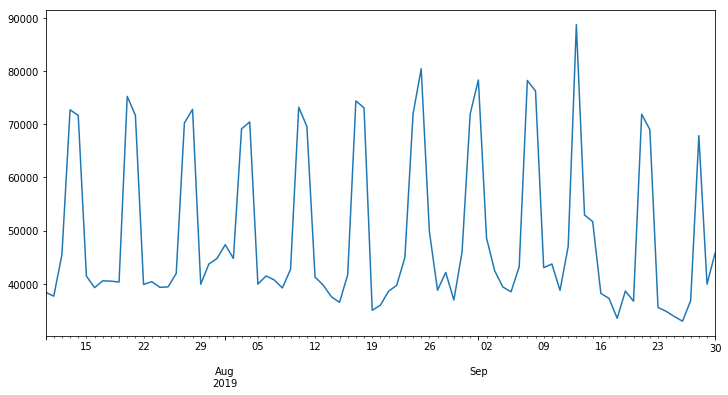

In [56]:
ts.plot(figsize=(12,6))

We can see it looks like stationary, but with a little trend, we can use Dickey-Fuller Test to caculate the truth.

Non-seasonal ARIMA models are generally denoted ARIMA(p,d,q) where parameters p, d, and q are non-negative integers, p is the order (number of time lags) of the autoregressive model, d is the degree of differencing (the number of times the data have had past values subtracted), and q is the order of the moving-average model. Seasonal ARIMA models are usually denoted ARIMA(p,d,q)(P,D,Q)m, where m refers to the number of periods in each season, and the uppercase P,D,Q refer to the autoregressive, differencing, and moving average terms for the seasonal part of the ARIMA model. [For more introduce](https://en.wikipedia.org/wiki/Autoregressive_integrated_moving_average)

So for us, we need determine the value of (p,d,q).

In [57]:
from statsmodels.tsa.stattools import adfuller
def test_stationarity(timeseries):
    
    #Determing rolling statistics
    rolmean = timeseries.rolling(window=12).mean()
    rolstd = timeseries.rolling(window=12).std()
 
    #Plot rolling statistics:
    fig = plt.figure(figsize=(12, 8))
    orig = plt.plot(timeseries, color='blue',label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show()
    
    #Perform Dickey-Fuller test:
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput)

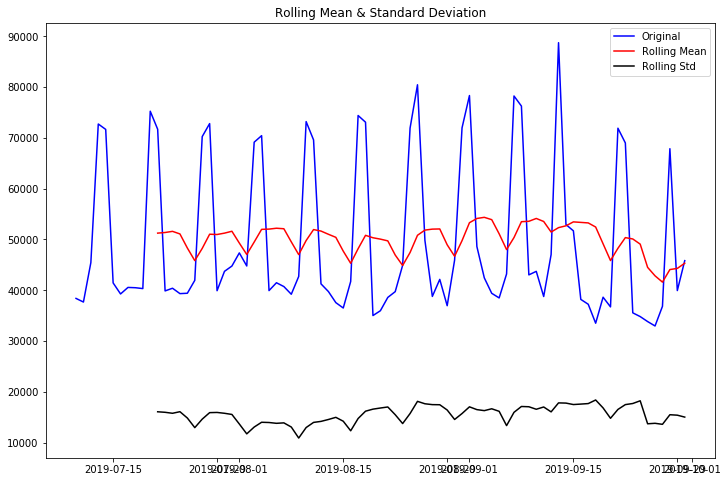

Results of Dickey-Fuller Test:
Test Statistic                 -1.927898
p-value                         0.319053
#Lags Used                      6.000000
Number of Observations Used    76.000000
Critical Value (1%)            -3.519481
Critical Value (5%)            -2.900395
Critical Value (10%)           -2.587498
dtype: float64


In [58]:
test_stationarity(ts)

The p-value is not less than 0.05, let's do order 1 diff.

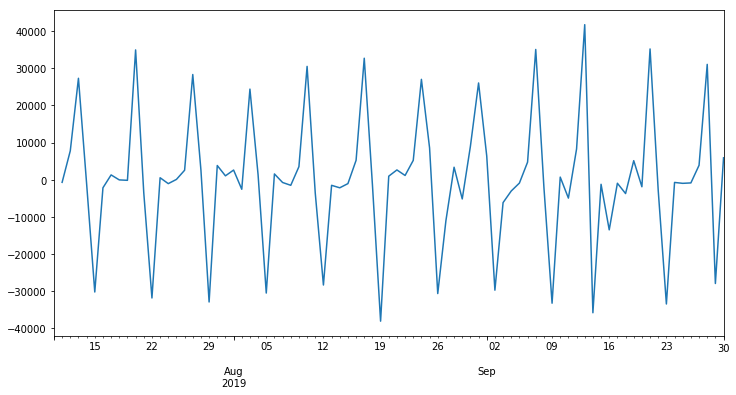

In [59]:
diff1 = ts.diff(1)
diff1.plot(figsize=(12,6))

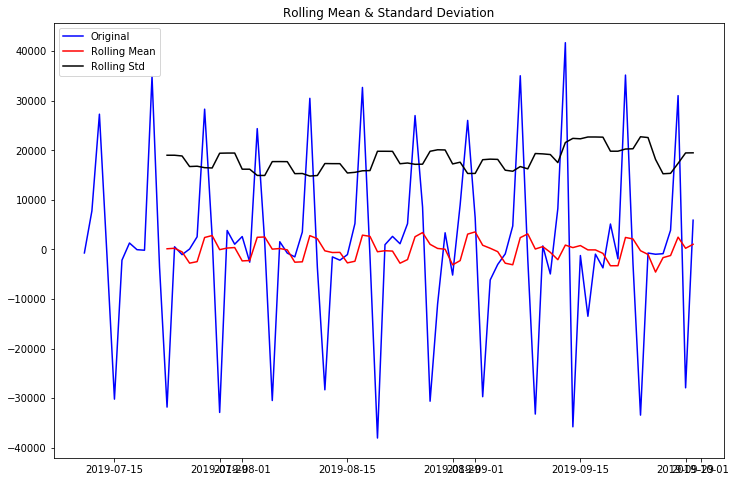

Results of Dickey-Fuller Test:
Test Statistic                 -4.053413
p-value                         0.001155
#Lags Used                     12.000000
Number of Observations Used    69.000000
Critical Value (1%)            -3.528890
Critical Value (5%)            -2.904440
Critical Value (10%)           -2.589656
dtype: float64


In [60]:
test_stationarity(diff1.dropna(inplace=False))

Now the p-value < 0.05 and Test Statistic < Critical Value (5%), we can use d = 1.

Plot ACF and PACF to find best value for p,q.

/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/statsmodels/regression/linear_model.py:1358: RuntimeWarning: invalid value encountered in sqrt
  return rho, np.sqrt(sigmasq)


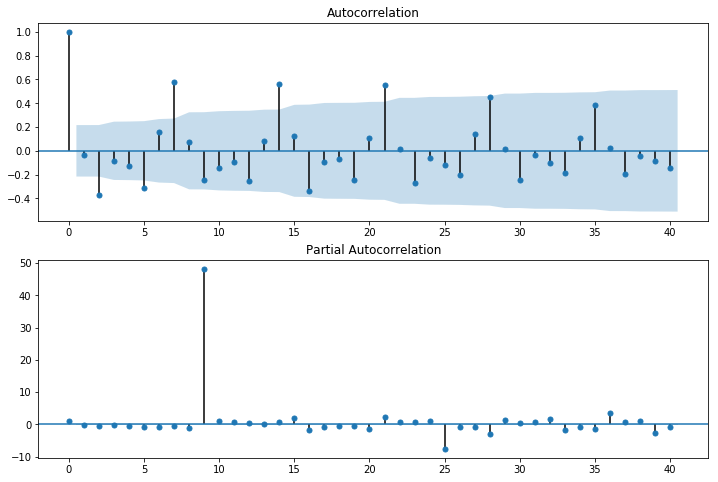

In [61]:
diff1.dropna(inplace=True)
fig = plt.figure(figsize=(12,8))
ax1=fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(diff1,lags=40,ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(diff1,lags=40,ax=ax2)

We will chose (p,d,q) = (2,1,2) first

In [19]:
from statsmodels.tsa.arima_model import ARIMA
from random import random

In [64]:
# fit model
model = ARIMA(df_train, order=(2, 1, 2))
model_fit = model.fit(disp=False)
# make prediction
yhat = model_fit.predict(start=end_training, end=end_test-1,typ='levels')
print(yhat)

2019-09-17    45775.182219
2019-09-18    55911.318842
2019-09-19    67426.332225
2019-09-20    64982.171851
2019-09-21    54455.196601
2019-09-22    46287.248491
2019-09-23    46147.436107
2019-09-24    51914.282983
2019-09-25    57515.134445
2019-09-26    58723.740375
2019-09-27    55894.392086
2019-09-28    52392.672533
2019-09-29    51149.856258
2019-09-30    52527.042882
Freq: D, dtype: float64


/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/ipykernel/__main__.py:5: FutureWarning: Addition/subtraction of integers and integer-arrays to Timestamp is deprecated, will be removed in a future version.  Instead of adding/subtracting `n`, use `n * self.freq`


In [65]:
model_fit.params

const         55.359592
ar.L1.D.87     0.946435
ar.L2.D.87    -0.717011
ma.L1.D.87    -1.756321
ma.L2.D.87     0.806691
dtype: float64

Plot the predict result with groundtruth.

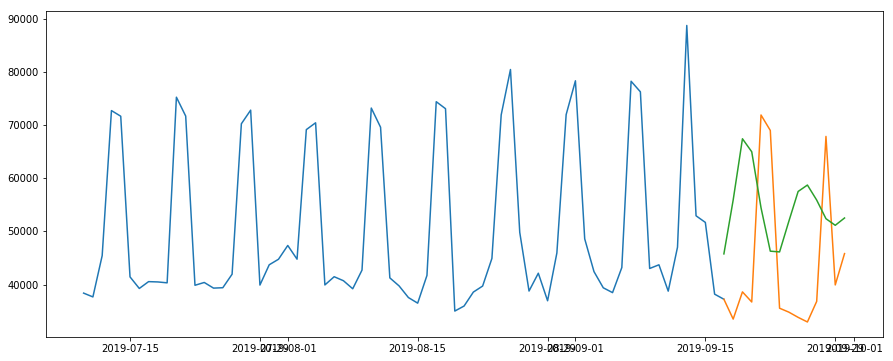

In [66]:
rcParams['figure.figsize'] = 15, 6
plt.plot(df_train, label="train")
plt.plot(df_test, label="valid")
plt.plot(yhat, label="Predictions")
plt.show()

You can try diffenent combination of (p,d,q), it is really hard to choose the value of (p,d,q), the good thing is we have **auto arima** to help us to choose, next we will show this.

In [ ]:
# if you get an error about not install setuptools-git, then run under command.
#!pip install setuptools-git

In [ ]:
!pip install pyramid-arima

In [25]:
from pyramid.arima import auto_arima

/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/pyramid/__init__.py:68: UserWarning: 
    The 'pyramid' package will be migrating to a new namespace beginning in 
    version 1.0.0: 'pmdarima'. This is due to a package name collision with the
    Pyramid web framework. For more information, see Issue #34:
    
        https://github.com/tgsmith61591/pyramid/issues/34
        
    The package will subsequently be installable via the name 'pmdarima'; the
    only functional change to the user will be the import name. All imports
    from 'pyramid' will change to 'pmdarima'.
    
  """, UserWarning)


We can assign the start value and max value of (p,d,q), then it will search the proper value for us. For params specific, check http://alkaline-ml.com/pmdarima/0.9.0/modules/generated/pyramid.arima.auto_arima.html

We will consider weekly seasonal. 

In [81]:
model = auto_arima(df_train, trace=True, seasonal=True, d=1, start_p=1, max_p =10, start_q=1, max_q=10, m=7, maxiter=500, random=False, n_fits=100, n_jobs =8, information_criterion ='bic', error_action='ignore', suppress_warning=True)

/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/pyramid/arima/auto.py:379: UserWarning: stepwise model cannot be fit in parallel (n_jobs=1). Falling back to stepwise parameter search.
  'Falling back to stepwise parameter search.' % n_jobs)
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/statsmodels/tsa/statespace/sarimax.py:993: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/statsmodels/tsa/statespace/sarimax.py:993: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'


Fit ARIMA: order=(1, 2, 1) seasonal_order=(1, 0, 1, 7); AIC=1522.972, BIC=1536.289, Fit time=0.061 seconds
Fit ARIMA: order=(0, 2, 0) seasonal_order=(0, 0, 0, 7); AIC=1573.193, BIC=1577.632, Fit time=0.005 seconds
Fit ARIMA: order=(1, 2, 0) seasonal_order=(1, 0, 0, 7); AIC=1537.344, BIC=1546.222, Fit time=0.026 seconds
Fit ARIMA: order=(0, 2, 1) seasonal_order=(0, 0, 1, 7); AIC=1498.644, BIC=1507.522, Fit time=0.215 seconds


/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/statsmodels/tsa/statespace/sarimax.py:993: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'


Fit ARIMA: order=(0, 2, 1) seasonal_order=(1, 0, 1, 7); AIC=1478.429, BIC=1489.527, Fit time=0.319 seconds
Fit ARIMA: order=(0, 2, 1) seasonal_order=(1, 0, 0, 7); AIC=1479.182, BIC=1488.060, Fit time=0.171 seconds


/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/statsmodels/tsa/statespace/sarimax.py:981: UserWarning: Non-stationary starting seasonal autoregressive Using zeros as starting parameters.
  warn('Non-stationary starting seasonal autoregressive'


Fit ARIMA: order=(0, 2, 1) seasonal_order=(2, 0, 1, 7); AIC=1521.329, BIC=1534.646, Fit time=0.856 seconds
Fit ARIMA: order=(1, 2, 1) seasonal_order=(1, 0, 0, 7); AIC=1521.020, BIC=1532.117, Fit time=0.086 seconds
Fit ARIMA: order=(0, 2, 0) seasonal_order=(1, 0, 0, 7); AIC=1537.346, BIC=1544.005, Fit time=0.104 seconds


/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/statsmodels/tsa/statespace/sarimax.py:961: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


Fit ARIMA: order=(0, 2, 2) seasonal_order=(1, 0, 0, 7); AIC=1470.941, BIC=1482.039, Fit time=0.221 seconds


/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/statsmodels/tsa/statespace/sarimax.py:961: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


Fit ARIMA: order=(1, 2, 3) seasonal_order=(1, 0, 0, 7); AIC=1468.398, BIC=1483.935, Fit time=0.917 seconds
Fit ARIMA: order=(0, 2, 2) seasonal_order=(0, 0, 0, 7); AIC=1534.288, BIC=1543.166, Fit time=0.150 seconds


/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/statsmodels/tsa/statespace/sarimax.py:961: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/statsmodels/tsa/statespace/sarimax.py:961: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/statsmodels/tsa/statespace/sarimax.py:981: UserWarning: Non-stationary starting seasonal autoregressive Using zeros as starting parameters.
  warn('Non-stationary starting seasonal autoregressive'


Fit ARIMA: order=(0, 2, 2) seasonal_order=(2, 0, 0, 7); AIC=1473.787, BIC=1487.104, Fit time=0.810 seconds


/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/statsmodels/tsa/statespace/sarimax.py:961: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/statsmodels/tsa/statespace/sarimax.py:993: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'


Fit ARIMA: order=(0, 2, 2) seasonal_order=(1, 0, 1, 7); AIC=1503.602, BIC=1516.919, Fit time=0.205 seconds


/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/statsmodels/tsa/statespace/sarimax.py:961: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/statsmodels/tsa/statespace/sarimax.py:981: UserWarning: Non-stationary starting seasonal autoregressive Using zeros as starting parameters.
  warn('Non-stationary starting seasonal autoregressive'


Fit ARIMA: order=(0, 2, 2) seasonal_order=(2, 0, 1, 7); AIC=1505.599, BIC=1521.135, Fit time=1.024 seconds
Fit ARIMA: order=(1, 2, 2) seasonal_order=(1, 0, 0, 7); AIC=1483.180, BIC=1496.497, Fit time=0.499 seconds


/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/statsmodels/tsa/statespace/sarimax.py:961: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


Fit ARIMA: order=(0, 2, 3) seasonal_order=(1, 0, 0, 7); AIC=1464.595, BIC=1477.912, Fit time=0.508 seconds


/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/statsmodels/tsa/statespace/sarimax.py:961: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


Fit ARIMA: order=(1, 2, 4) seasonal_order=(1, 0, 0, 7); AIC=1483.237, BIC=1500.993, Fit time=0.669 seconds


/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/statsmodels/tsa/statespace/sarimax.py:961: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


Fit ARIMA: order=(0, 2, 3) seasonal_order=(0, 0, 0, 7); AIC=1509.463, BIC=1520.560, Fit time=0.231 seconds


/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/statsmodels/tsa/statespace/sarimax.py:961: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/statsmodels/tsa/statespace/sarimax.py:981: UserWarning: Non-stationary starting seasonal autoregressive Using zeros as starting parameters.
  warn('Non-stationary starting seasonal autoregressive'


Fit ARIMA: order=(0, 2, 3) seasonal_order=(2, 0, 0, 7); AIC=1463.879, BIC=1479.415, Fit time=1.820 seconds


/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/statsmodels/tsa/statespace/sarimax.py:961: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/statsmodels/tsa/statespace/sarimax.py:993: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'


Fit ARIMA: order=(0, 2, 3) seasonal_order=(1, 0, 1, 7); AIC=1464.014, BIC=1479.550, Fit time=0.755 seconds


/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/statsmodels/tsa/statespace/sarimax.py:961: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/statsmodels/tsa/statespace/sarimax.py:981: UserWarning: Non-stationary starting seasonal autoregressive Using zeros as starting parameters.
  warn('Non-stationary starting seasonal autoregressive'


Fit ARIMA: order=(0, 2, 3) seasonal_order=(2, 0, 1, 7); AIC=1515.663, BIC=1533.419, Fit time=1.901 seconds


/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/statsmodels/tsa/statespace/sarimax.py:961: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


Fit ARIMA: order=(0, 2, 4) seasonal_order=(1, 0, 0, 7); AIC=1466.552, BIC=1482.088, Fit time=0.431 seconds
Total fit time: 11.990 seconds


In [82]:
forecast = model.predict(n_periods=14)
forecast

array([36224.49180551, 44286.77373305, 78084.04759749, 48682.06712504,
       47456.03579702, 36233.74509232, 35230.32990199, 34173.65056292,
       40518.03608199, 67842.35838721, 43632.56152095, 42392.97757127,
       32999.24465619, 31934.11811575])

In [159]:
model.params()

array([ 1.60369565e+01, -9.98664860e-01,  8.49530331e-01,  8.43671440e+07])

Show out modle's parameters.

In [83]:
model.get_params()

{'callback': None,
 'disp': 0,
 'maxiter': 500,
 'method': None,
 'order': (0, 2, 3),
 'out_of_sample_size': 0,
 'scoring': 'mse',
 'scoring_args': {},
 'seasonal_order': (1, 0, 0, 7),
 'solver': 'lbfgs',
 'start_params': None,
 'suppress_warnings': False,
 'transparams': True,
 'trend': 'c'}

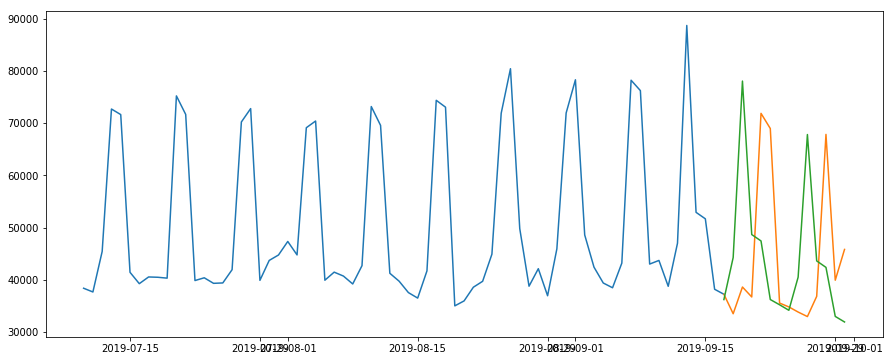

In [84]:
rcParams['figure.figsize'] = 15, 6
forecast = pd.DataFrame(forecast, index=df_test.index, columns=['Predictions'])
plt.plot(df_train, label="train")
plt.plot(df_test, label="valid")
plt.plot(forecast, label="Predictions")
plt.show()

It fits better than before.

You can try other values combination or other time series, here we just want to show how to use it. 
